In [1]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.stats import norm
from scipy.integrate import trapz
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.widgets import Slider
from scipy.stats import linregress

%matplotlib inline
%matplotlib notebook

npr.seed(123)

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
mean, std, N = 0, 1,100
x = npr.normal(mean, std, size = N)

**Version one - Animated plot with non normalized KDE**

<IPython.core.display.Javascript object>


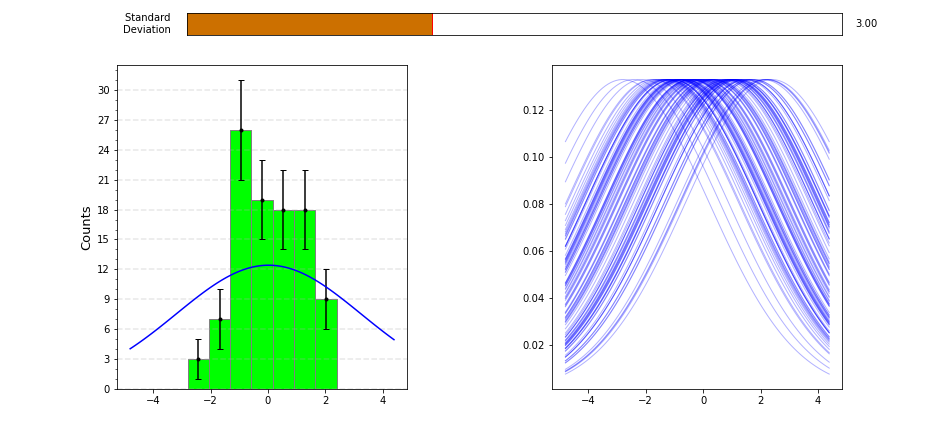

In [3]:
def hist(axe):
    counts, bins, _ = axe.hist(x, bins = "scott", facecolor = "lime", edgecolor = "gray")                                                     
    bin_centers = bins[:-1] + 0.5*np.diff(bins)
    Poissons = np.round(np.sqrt(counts)) 
    ax1.errorbar(bin_centers, counts, yerr = Poissons, fmt = ".k", capsize = 3)
    ax1.set_ylabel("Counts", fontsize = 13)
    ax1.yaxis.set_major_locator(MultipleLocator(3))
    ax1.yaxis.set_major_formatter("{x:.0f}")
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.grid(axis = "y", linestyle = '--', linewidth = 1.5, alpha = 0.3)
    
def update(val):
    std = s_std.val
    N = np.zeros(len(z))
    
    for j in range(len(x)):
        normal0[j].set_data(z, norm.pdf(z, loc = x[j], scale = std)) 
        N = N + norm.pdf(z, loc = x[j], scale = std)    
           
    ax1.cla()
    hist(ax1)
    ax1.plot(z, N, 'k-', color = "b", lw = 1.5)
    fig.canvas.draw_idle()
    
# /np.trapz(N, z.reshape(100,))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 6))   
fig.subplots_adjust(bottom=0.1, top=0.85, wspace=0.5)
hist(ax1)

z = np.linspace(x.min()-2, x.max()+2, 100).reshape(100, 1)
sig = 1.06*x.std()*(x.size**(1/5))
ax_std = fig.add_axes([0.2, 0.92, 0.7, 0.05])
s_std = Slider(ax_std, label = "Standard \nDeviation ", valmin = 0.015, valmax = 8, valinit = sig, valfmt = "%1.2f",
               facecolor = "#cc7000")
normal = norm.pdf(z, loc = x, scale = sig)
normal0 = ax2.plot(z, normal, 'k-', color = "b", lw = 1, alpha = 0.3)
ax1.plot(z, np.sum(normal, axis=1), 'k-', color = "b", lw = 1.5)
s_std.on_changed(update)

plt.show()

**Version two - Normalized KDE**

<IPython.core.display.Javascript object>


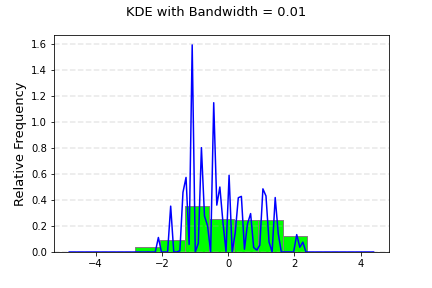

<IPython.core.display.Javascript object>


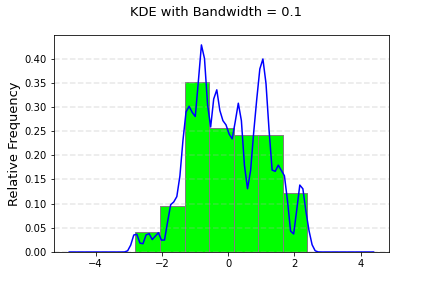

<IPython.core.display.Javascript object>


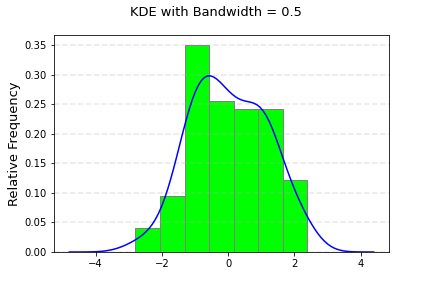

<IPython.core.display.Javascript object>


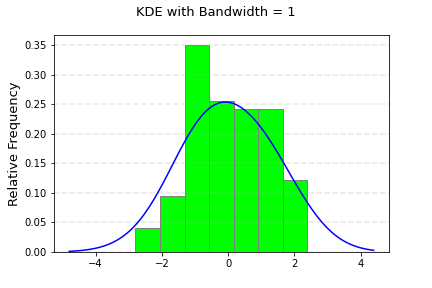

<IPython.core.display.Javascript object>


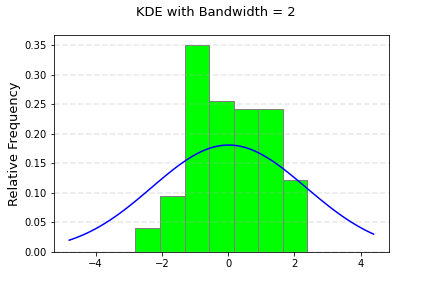

<IPython.core.display.Javascript object>


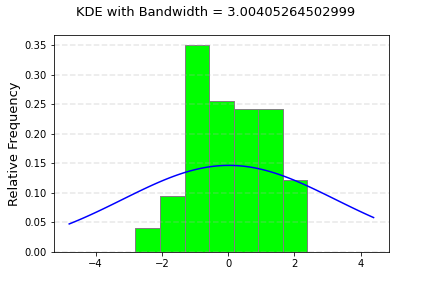

<IPython.core.display.Javascript object>


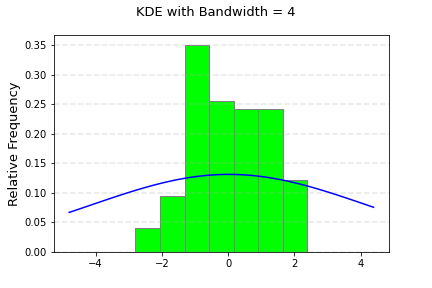

In [4]:
def KDE(sigma):
    normal = norm.pdf(z, loc = x, scale = sigma)
    normal_tot = np.sum(normal.T, axis = 0)
    KDE = normal_tot/np.trapz(normal_tot, z.reshape(100))

    fig, ax = plt.subplots(1, 1)  
    count, binn, _ = ax.hist(x, bins = "scott", density = True, facecolor = "lime", edgecolor = "gray") 
    bin_center = binn[:-1] + 0.5*np.diff(binn)
    Poisson = np.sqrt(count)
    ax.set_ylabel("Relative Frequency", fontsize = 13)
    ax.grid(axis = "y", linestyle = '--', linewidth = 1.5, alpha = 0.3)
    ax.plot(z, KDE, 'k-', color = "b", lw = 1.5)
    plt.suptitle("KDE with Bandwidth = "+str(sigma), fontsize = 13)
    plt.show()

sigm = [0.01, 0.1, 0.5, 1, 2, sig, 4]
for s in sigm: KDE(s)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

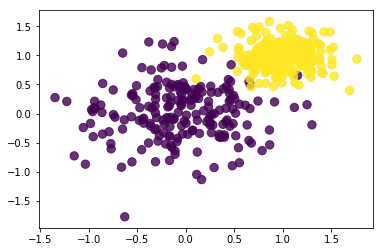

In [5]:
# !wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
    
from IPython.display import Image
Image('two_categories_scatter_plot.png')

**Version one**

In [23]:
n = 5

In [7]:
rng = npr.default_rng()

while True:
    a = float(input("\nInsert initial range number => a = "))
    b = float(input("Insert final range number (a < b) => b = "))
    if (a < b):
        break


Insert initial range number => a = 7
Insert final range number (a < b) => b = 103


<IPython.core.display.Javascript object>


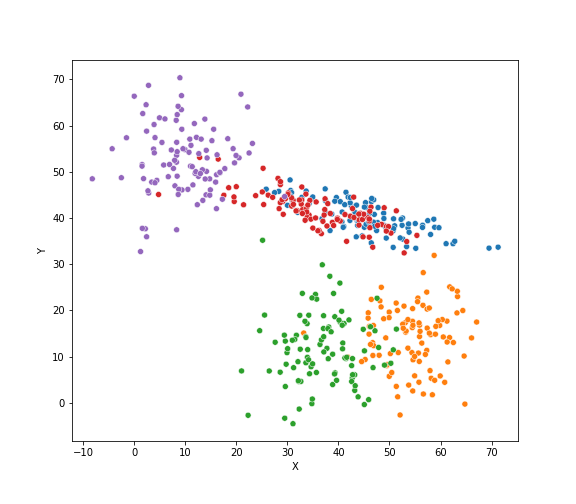

In [25]:
def genCovariance1(d):
    random = rng.integers(1, 150)
    dfg = pd.DataFrame(np.random.randint(1, 25, size = (random, d)))
    return np.cov(dfg.T)

def gaussianData1(num):  
    df = pd.DataFrame()
    for i in range(num):
        mean = rng.uniform(a, b, 2)
        temp = pd.DataFrame(npr.multivariate_normal(mean, genCovariance1(2), 100), columns = ["X", "Y"])
        temp["categ"] = chr(161 + i)
        temp["categ"] = temp.categ.astype("category")
        df = pd.concat([df, temp], axis = 0, ignore_index = True)
    return df

fig, ax = plt.subplots(1, 1, figsize = (8, 7))

dataset = gaussianData1(n)
sns.scatterplot(x = "X", y = "Y", hue = "categ", data = dataset, legend = False, ax=ax);

<IPython.core.display.Javascript object>


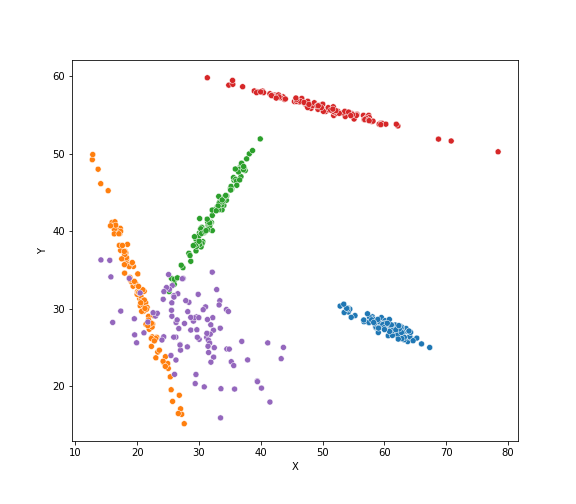

In [26]:
def genCovariance2(d):
    while True:
        random = rng.integers(15)
        A = rng.uniform(0, random, size = (d, d))
        cov = np.dot(A, A.T)
        sign = (-1)**rng.integers(2)
        cov[0,1], cov[1,0] = cov[0,1]*sign, cov[1,0]*sign
        if not(np.array_equal(cov, np.zeros((d,d)))):
            return cov
            break
            
def gaussianData2(num):  
    df = pd.DataFrame()
    for i in range(num):
        mean = rng.uniform(a, b, 2)
        temp = pd.DataFrame(npr.multivariate_normal(mean, genCovariance2(2), 100), columns = ["X", "Y"])
        temp["categ"] = chr(161 + i)
        temp["categ"] = temp.categ.astype("category")
        df = pd.concat([df, temp], axis = 0, ignore_index = True)
    return df

            
fig, ax = plt.subplots(1, 1, figsize = (8, 7))

dataset = gaussianData2(n)
sns.scatterplot(x = "X", y = "Y", hue = "categ", data = dataset, legend = False, ax=ax);

**Version two**

In [10]:
n = 3

In [11]:
rng = npr.default_rng()

while True:
    a = float(input("\nInsert initial range number => a = "))
    b = float(input("Insert final range number (a < b) => b = "))
    if (a < b):
        break


Insert initial range number => a = 2
Insert final range number (a < b) => b = 62


<IPython.core.display.Javascript object>


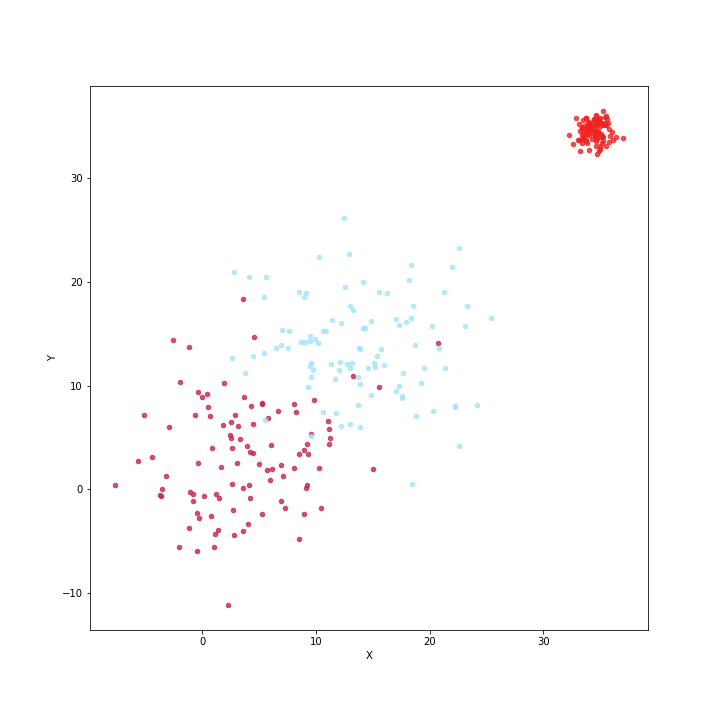

In [20]:
def gaussianScatter():
    mean = rng.uniform(a, b)
    random = rng.integers(low = 0, high = 10)
    std = 5*rng.random()
    df = pd.DataFrame(rng.normal(loc = mean, scale = std, size = (100, 2)), columns = ["X", "Y"])
    df.plot.scatter(x = "X", y = "Y", color = "#%06X"%npr.randint(0, 0xFFFFFF), alpha = 0.8, ax = ax)


    
fig = plt.figure(figsize = (10, 10))
ax = plt.gca()
ax.grid()

for i in range(n): gaussianScatter()
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [13]:
# !wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

data = np.load("residuals_261.npy", allow_pickle = True).item()
data_df = pd.DataFrame(data)

data_df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [14]:
data_df = data_df[abs(data_df.residuals) < 2]

data_df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [15]:
res = linregress(data_df.residuals, data_df.distances)

<IPython.core.display.Javascript object>


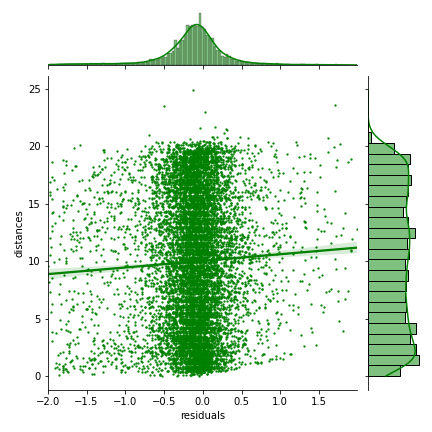

In [16]:
sns.jointplot(x = data_df.residuals, y = data_df.distances, data = data_df, kind="reg", color = "g",
              joint_kws = {"scatter_kws": dict(alpha = 0.1)}, scatter_kws={"s": 2});

In [17]:
mod_df = data_df.copy()
mod_df = mod_df[data_df.distances < 20]

_, bins = np.histogram(mod_df.distances, bins = "fd")
x = bins[:-1] + 0.5*np.diff(bins)
df_profile = pd.DataFrame(x, columns = ["x"])

step = np.diff(bins)[0]
y = [mod_df[(bins[i] <= mod_df.distances) & (mod_df.distances <= bins[i] + step)].residuals.mean() for i in range(len(bins)-1)]
df_profile["y"] = y

erry = [mod_df[(bins[i] <= mod_df.distances) & (mod_df.distances < bins[i] + step)].residuals.std() for i in range(len(bins)-1)]
df_profile["erry"] = erry

<IPython.core.display.Javascript object>


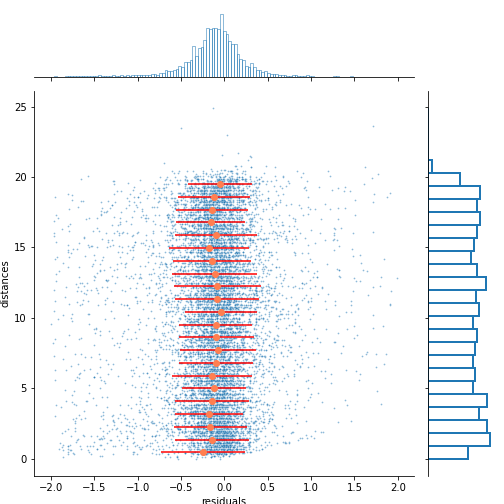

In [18]:
g = sns.JointGrid(height = 7)
sns.scatterplot(x = data_df.residuals, y = data_df.distances, s= 3, alpha = 0.5, ax = g.ax_joint)
sns.histplot(x = data_df.residuals, fill = False, ax = g.ax_marg_x)
sns.histplot(y = data_df.distances, fill = False, linewidth = 2, ax = g.ax_marg_y)
g.ax_joint.errorbar(y, x, xerr = erry, color = "coral", ecolor = "r", fmt = 'o')
plt.show()